# Case

Business Problem: Predicting which class (average, highlighted) players are according to the scores given to the characteristics of the football players watched by the Scouts.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)
import warnings
warnings.simplefilter(action="ignore")

In [2]:
df_a=pd.read_csv("/kaggle/input/scoutium/scoutium_attributes.csv", sep=";")
df_p=pd.read_csv("/kaggle/input/scoutium/scoutium_potential_labels.csv", sep=";")

# Preparing Data

In [3]:
df_a.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.000
1,4915,62935,177676,1361061,2,12818495,4323,56.000
2,4915,62935,177676,1361061,2,12818495,4324,67.000
3,4915,62935,177676,1361061,2,12818495,4325,56.000
4,4915,62935,177676,1361061,2,12818495,4326,45.000


In [4]:
df_p.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [5]:
df=pd.merge(df_a, df_p, on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Duplicated Values #####################")
    print(dataframe.duplicated().sum())
    print("##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Number of Unique Values #####################")
    print(df.nunique())
    
check_df(df)

##################### Shape #####################
(10730, 9)
##################### Types #####################
task_response_id      int64
match_id              int64
evaluator_id          int64
player_id             int64
position_id           int64
analysis_id           int64
attribute_id          int64
attribute_value     float64
potential_label      object
dtype: object
##################### Duplicated Values #####################
0
##################### Missing Values #####################
task_response_id    0
match_id            0
evaluator_id        0
player_id           0
position_id         0
analysis_id         0
attribute_id        0
attribute_value     0
potential_label     0
dtype: int64
##################### Number of Unique Values #####################
task_response_id     29
match_id             17
evaluator_id         10
player_id           277
position_id          10
analysis_id         323
attribute_id         39
attribute_value      10
potential_label       3
dtype

In [7]:
df=df[df["position_id"]!=1]
df["position_id"].nunique()

9

In [8]:
df=df[df["potential_label"]!= "below_average"]
df["potential_label"].nunique()

2

In [9]:
df_pivoted=df.pivot_table(index=["player_id","position_id","potential_label"],
                 columns="attribute_id",
                 values="attribute_value")
df_pivoted.reset_index(inplace=True)
df_pivoted.columns=df_pivoted.columns.astype(str)
df_pivoted.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [10]:
num_cols= [col for col in df_pivoted.columns if col not in ["attribute_id", "player_id","position_id", "potential_label"]]
print(num_cols)

['4322', '4323', '4324', '4325', '4326', '4327', '4328', '4329', '4330', '4332', '4333', '4335', '4338', '4339', '4340', '4341', '4342', '4343', '4344', '4345', '4348', '4349', '4350', '4351', '4352', '4353', '4354', '4355', '4356', '4357', '4407', '4408', '4423', '4426']


# Label Encoding

In [11]:
df_pivoted["potential_label"]=LabelEncoder().fit_transform(df_pivoted["potential_label"])
df_pivoted.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,0,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,0,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


# Scale

In [12]:
df_pivoted[num_cols]=StandardScaler().fit_transform(df_pivoted[num_cols])
df_pivoted.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.543,-0.559,-1.405,-0.438,-0.767,-0.795,-0.907,-0.792,-0.446,-0.123,-1.224,-1.036,-1.126,-1.009,-0.542,-0.690,-0.535,-1.067,-1.206,-1.005,-1.314,-1.042,-0.693,-0.436,0.013,-1.282,-1.132,-0.495,-1.235,-1.520,-0.143,-1.487,-0.955,-0.253
1,1356362,9,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,0.404,0.728,0.691,0.459,0.996,0.632,0.840,0.912,0.799,0.588,1.230,0.750,0.742,0.879,0.670,0.848,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
2,1356375,3,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,1.002,0.728,0.691,1.132,0.319,0.632,0.840,0.912,0.799,0.588,0.574,0.750,0.742,0.879,0.670,0.077,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042
3,1356375,4,0,0.595,1.308,0.679,0.683,0.723,1.482,1.355,1.002,-0.055,0.691,0.459,0.996,1.335,1.580,0.185,0.799,0.588,-0.083,0.098,0.043,0.879,1.355,0.848,0.717,1.560,0.814,0.428,0.632,0.198,0.768,-0.143,0.669,-0.276,-0.253
4,1356411,9,0,0.595,0.561,1.373,1.430,0.723,0.723,0.601,0.404,2.294,1.505,0.459,0.996,0.632,0.101,0.185,0.799,1.337,0.574,0.750,0.742,0.252,1.355,0.077,0.717,0.787,0.115,0.428,0.632,0.198,0.768,1.874,-0.050,1.083,1.042


# Modelling

In [13]:
y=df_pivoted["potential_label"]
X=df_pivoted.drop(["potential_label", "player_id"],  axis=1)

In [14]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    models = [('LR', LogisticRegression()),
          ("KNN", KNeighborsClassifier()),
          ("CART", DecisionTreeClassifier()),
          ("RF", RandomForestClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
          ('CatBoost', CatBoostClassifier(verbose=False))
             ]

    for name, classifier in models:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [15]:
base_models(X,y)

Base Models....
roc_auc: 0.8177 (LR) 
roc_auc: 0.6914 (KNN) 
roc_auc: 0.6961 (CART) 
roc_auc: 0.8837 (RF) 
roc_auc: 0.8645 (GBM) 
roc_auc: 0.8544 (XGBoost) 
roc_auc: 0.8924 (CatBoost) 


In [16]:
base_models(X,y,scoring="f1")

Base Models....
f1: 0.537 (LR) 
f1: 0.3457 (KNN) 
f1: 0.4872 (CART) 
f1: 0.6249 (RF) 
f1: 0.6153 (GBM) 
f1: 0.5865 (XGBoost) 
f1: 0.6066 (CatBoost) 


In [17]:
base_models(X,y,scoring="recall")

Base Models....
recall: 0.4454 (LR) 
recall: 0.2154 (KNN) 
recall: 0.4639 (CART) 
recall: 0.4288 (RF) 
recall: 0.5175 (GBM) 
recall: 0.5156 (XGBoost) 
recall: 0.4805 (CatBoost) 


In [18]:
base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.8486 (LR) 
accuracy: 0.8339 (KNN) 
accuracy: 0.8193 (CART) 
accuracy: 0.8598 (RF) 
accuracy: 0.8597 (GBM) 
accuracy: 0.8524 (XGBoost) 
accuracy: 0.8744 (CatBoost) 


In [19]:
base_models(X, y, scoring="precision")

Base Models....
precision: 0.7331 (LR) 
precision: 0.9444 (KNN) 
precision: 0.5651 (CART) 
precision: 0.9333 (RF) 
precision: 0.7257 (GBM) 
precision: 0.7004 (XGBoost) 
precision: 0.8524 (CatBoost) 


# Hyperparameter Optimization

In [20]:
catboost_model = CatBoostClassifier(random_state=17, verbose=False)
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}
catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=False).fit(X, y)
catboost_final = catboost_model.set_params(**catboost_grid.best_params_, random_state=17).fit(X, y)

In [21]:
cv_results = cross_validate(catboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision"])

print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean() )
print(cv_results['test_roc_auc'].mean())
print(cv_results['test_precision'].mean() )

0.8930639730639731
0.6860566448801743
0.8938336856941509
0.8933333333333333


# Feature Importance

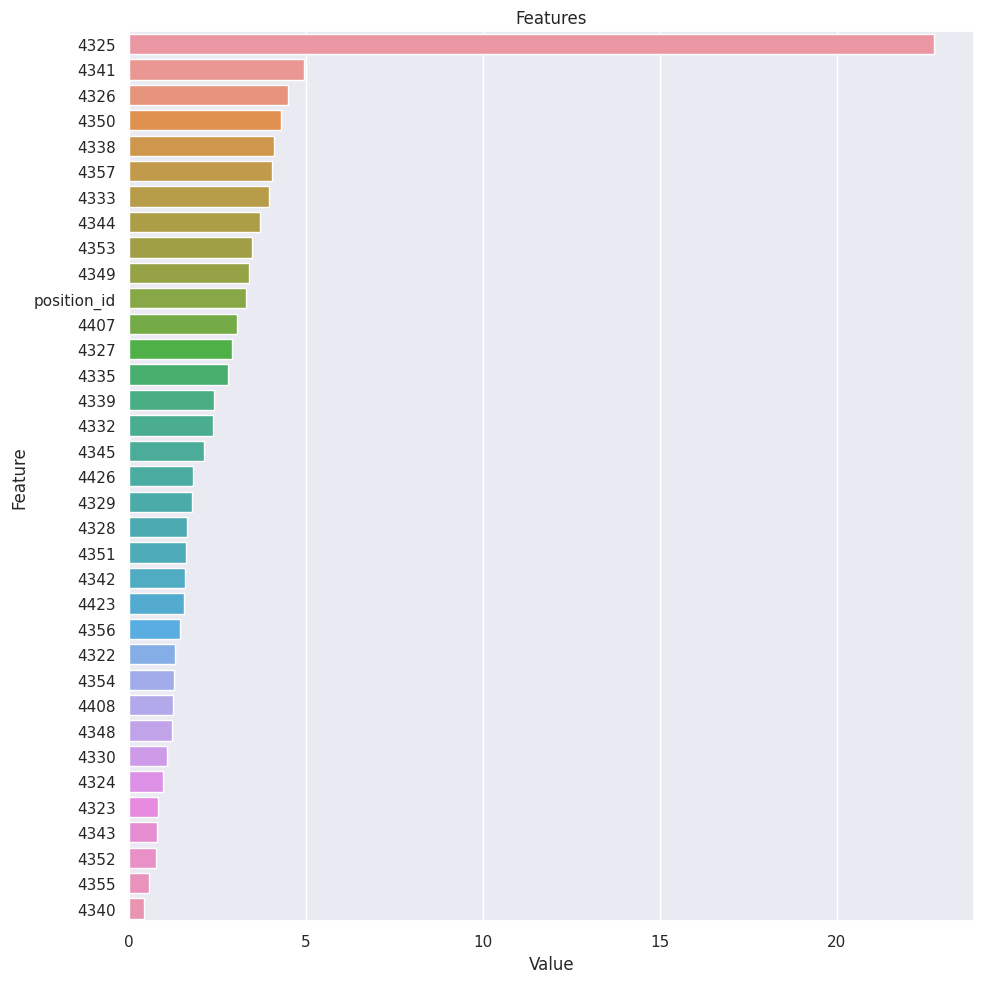

In [22]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(catboost_final, X)